Let’s see how regularization affects the quality of classification on a dataset on microchip testing from Andrew Ng’s course on machine learning. We will use logistic regression with polynomial features and vary the regularization parameter 
$C$. First, we will see how regularization affects the separating border of the classifier and intuitively recognize under- and overfitting. Then, we will choose the regularization parameter to be numerically close to the optimal value via (cross-validation) and (GridSearch).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
#sharper plots
%config InlineBackend.figure_format = 'retina'


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.preprocessing import PolynomialFeatures

Let’s load the data using read_csv from the pandas library. In this dataset on 118 microchips (objects), there are results for two tests of quality control (two numerical variables) and information whether the microchip went into production. Variables are already centered, meaning that the column values have had their own mean values subtracted. Thus, the “average” microchip corresponds to a zero value in the test results.

In [2]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [4]:
data = pd.read_csv(
    DATA_PATH + "microchip_tests.txt",
    header = None,
    names = ["test1", "test2", "released"],
)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


Lets inspect the first 5 and the last 5 rows of the data

In [5]:
data.head(5)

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [6]:
data.tail(5)

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


We shall save the data and the labels in seperate variables

In [24]:
X = data[["test1", "test2"]].values
y = data["released"].values


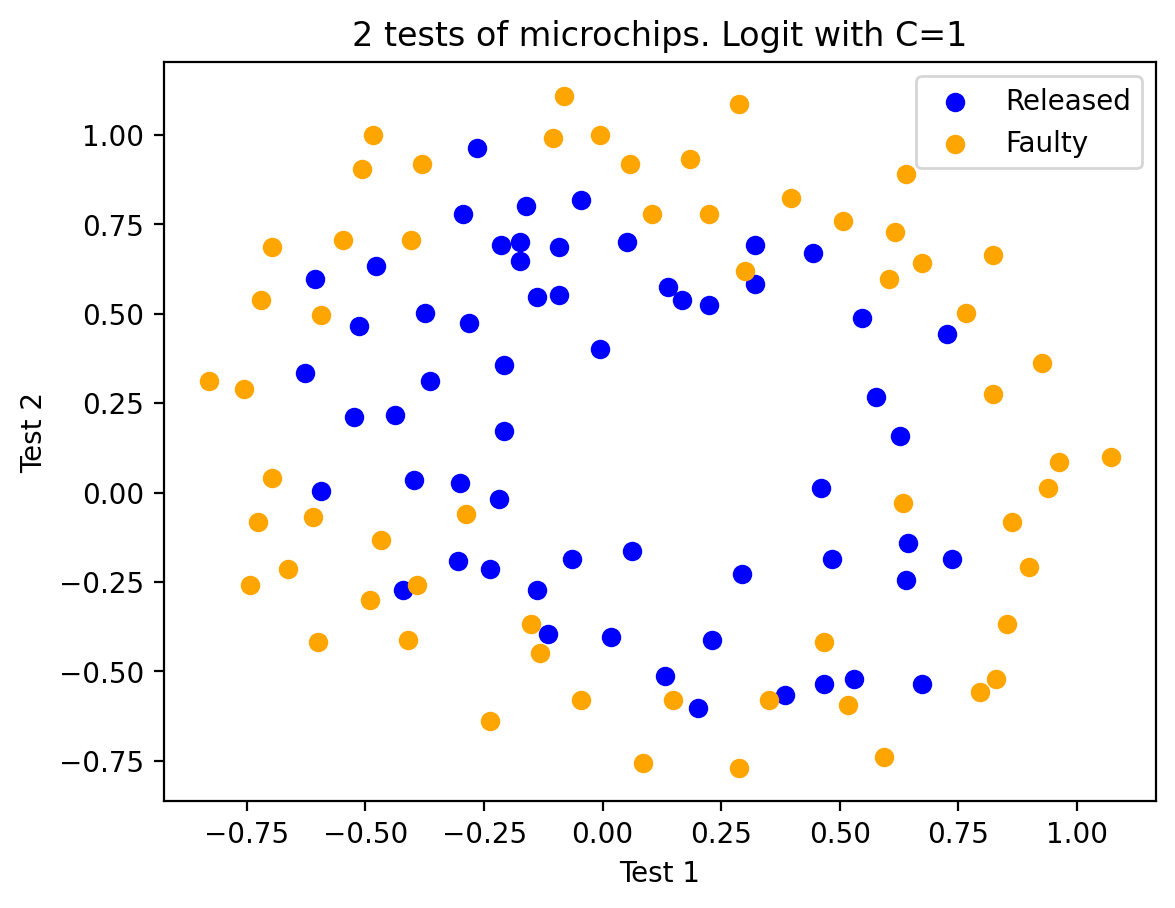

In [26]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=1")
plt.legend();

Let’s define a function to display the separating curve of the classifier.

In [40]:
def plot_boundary(clf, X, y, grid_step=0.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step), np.arange(y_min, y_max, grid_step)
    )

    # to every point from [x_min, m_max]x[y_min, y_max]
    # we put in correspondence its own color
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

We define the following polynomial features of degree $d$ for two variables 
$x_1$ and $x_2$ : $$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} =  \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N}}$$ 

For example, for $d=3$, this will be the following features:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$

Drawing a Pythagorean Triangle would show how many of these features there will be for $d = 4,5$ and so on. The number of such features is exponentially large, and it can be costly to build polynomial features of large degree (e.g $d=10$) for 100 variables. More importantly, it’s not needed.

We will use sklearn’s implementation of logistic regression. So, we create an object that will add polynomial features up to degree 7 to matrix $X$.



In [65]:
poly = PolynomialFeatures(degree=7)

X_poly = poly.fit_transform(X)


In [66]:
X_poly.shape

(118, 36)

Let’s train logistic regression with regularization parameter $C = 10^{-2}$.


Accuracy on training set: 0.627


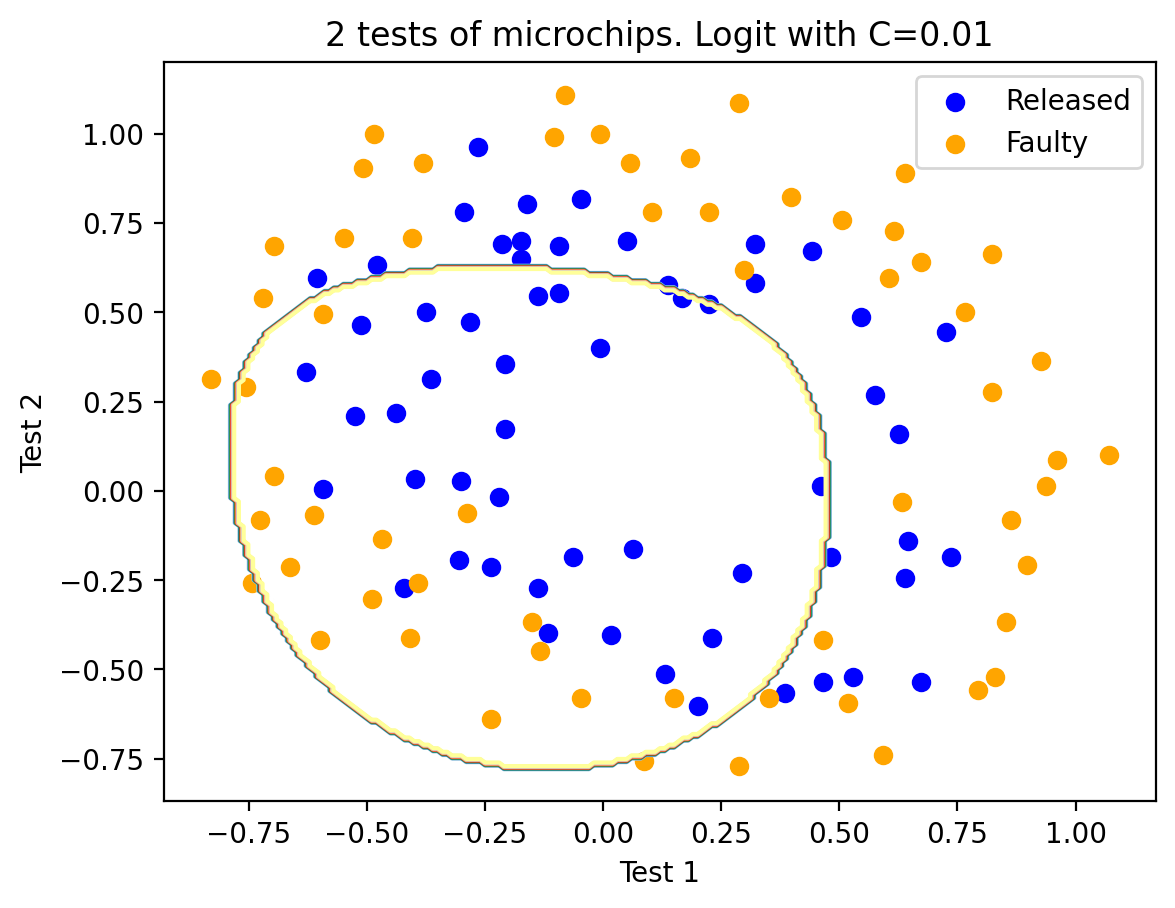

In [67]:
C = 1e-2
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly , y)

plot_boundary(logit, X, y, grid_step=0.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

We could now try increasing $C$ to 1. In doing this, we weaken regularization, and the solution can now have greater values (in absolute value) of model weights than previously. Now the accuracy of the classifier on the training set improves to 0.831.

Accuracy on training set: 0.831


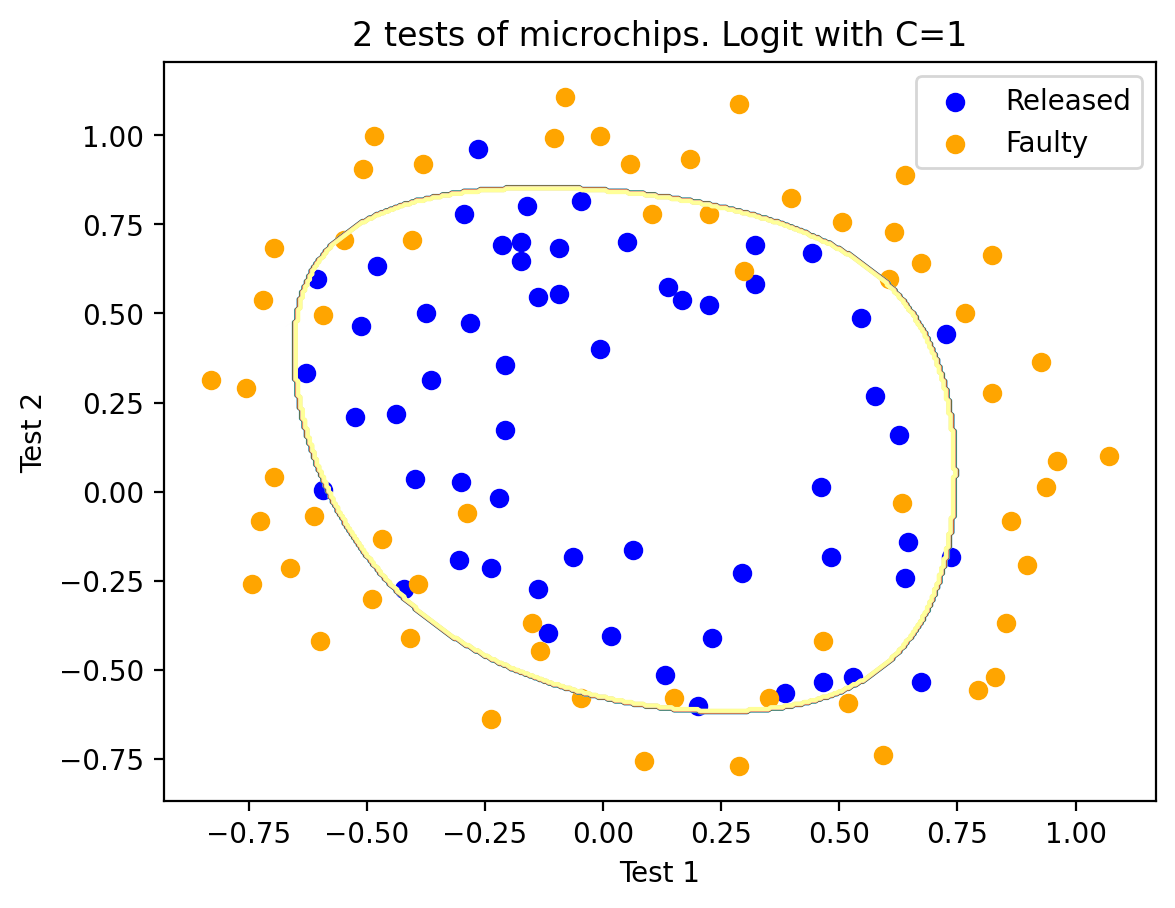

In [68]:
C = 1
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

Then, why don’t we increase $C$ even more - up to 10,000? Now, regularization is clearly not strong enough, and we see overfitting. Note that, with 
=1 and a “smooth” boundary, the share of correct answers on the training set is not much lower than here. But one can easily imagine how our second model will work much better on new data.

Accuracy on training set: 0.873


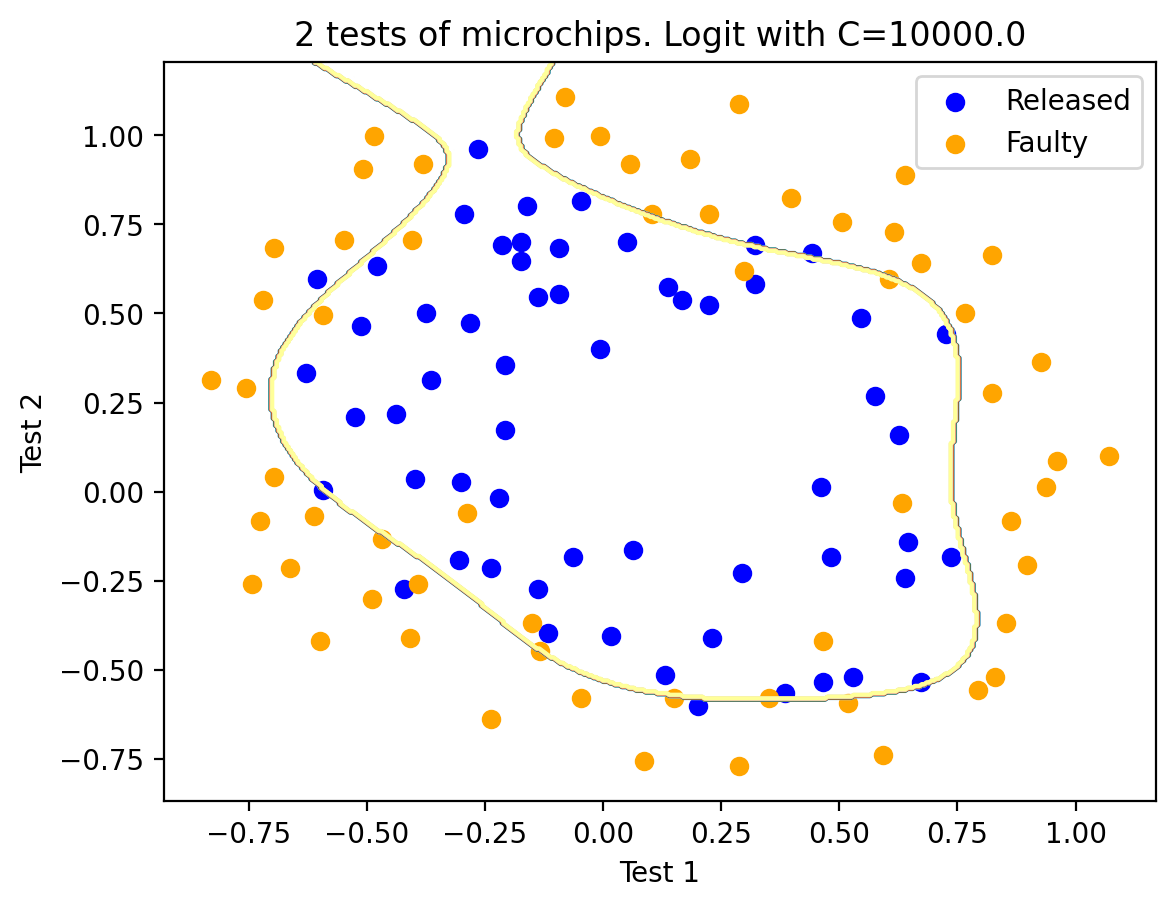

In [69]:
C = 1e4
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

Using this example, let’s identify the optimal value of the regularization parameter $C$. This can be done using LogisticRegressionCV - a grid search of parameters followed by cross-validation. This class is designed specifically for logistic regression (effective algorithms with well-known search parameters). For an arbitrary model, use GridSearchCV, RandomizedSearchCV, or special algorithms for hyperparameter optimization such as the one implemented in hyperopt.

In [72]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs= c_values, cv=skf, n_jobs = -1, random_state=17)
logit_searcher.fit(X_poly, y);

In [73]:
logit_searcher.C_

array([157.90533145])

We can see here that after searching throught the range of C values , the searcher has chosen $C=157.90533145$ as the optimal value. Lets try and visulaise the decision boundary with this $C$ value

Accuracy on training set: 0.839


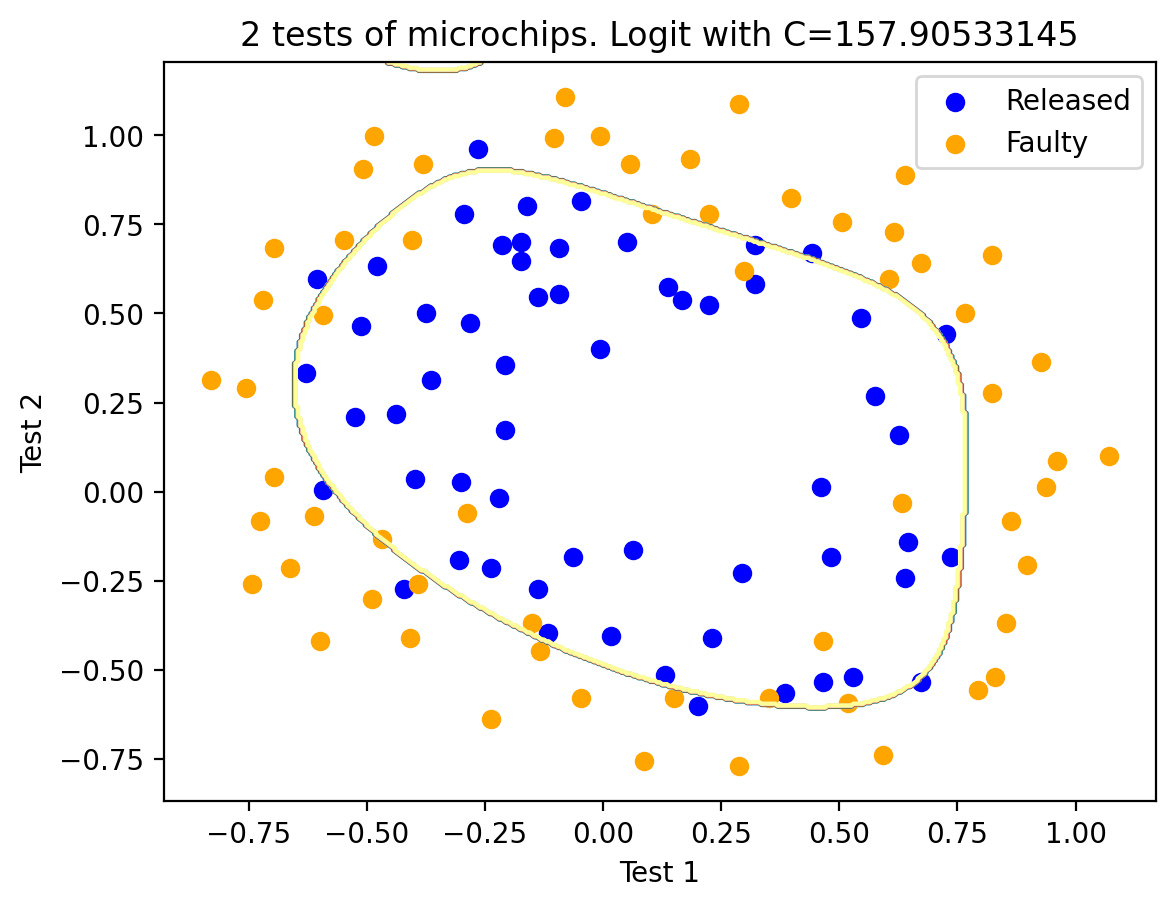

In [75]:
C = 157.90533145
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

We can see the decision boundary to be smooth and continuos without much overfitting